In [1]:
! pip install ta

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# For prepare data
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import ta
from ta import add_all_ta_features
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import MACD, ADXIndicator

from tqdm import tqdm

# For modeling
import math
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch import optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
# from pytorch_optimizer import SAM

# Prepare data

In [3]:
# 1. Hàm load data
def load_data(file_path):
    df = pd.read_csv(file_path)
    # Xử lý datetime
    # df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    # df = df.sort_values('Datetime').drop(['Date', 'Time'], axis=1)
    df['Datetime'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Datetime').drop(['Date'], axis=1)
    return df

train_df = load_data("data/xauusd/1m/dynamic_labeled_train.csv")
val_df = load_data("data/xauusd/1m/dynamic_labeled_dev.csv")
test_df = load_data("data/xauusd/1m/dynamic_labeled_test.csv")

# train_df = train_df.loc[train_df['Datetime'].dt.year.isin(range(2018, 2021))]

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446549 entries, 0 to 3446548
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Open      float64       
 1   High      float64       
 2   Low       float64       
 3   Close     float64       
 4   Volume    int64         
 5   Label     object        
 6   Datetime  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 184.1+ MB


In [4]:
label_mapping = {
    'BUY': 0,
    'SELL': 1,
    'HOLD': 2
}

def map_label(x):
    return label_mapping[x] if x in label_mapping else x

# train_df['Label'] = train_df['Label'].map(map_label)
# val_df['Label'] = val_df['Label'].map(map_label)
# test_df['Label'] = test_df['Label'].map(map_label)

In [5]:
def add_technical_indicators(df):
    """Thêm các chỉ báo kỹ thuật."""
    print("Thêm các chỉ báo kỹ thuật...")
    # Momentum
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    df['Momentum'] = ta.momentum.ROCIndicator(df['Close']).roc()
    df['CMO'] = ta.momentum.kama(df['Close'])
    df['Williams_%R'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()
    # Volatility
    df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_Mid'] = bb.bollinger_mavg()
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()
    df['BB_Bandwidth'] = bb.bollinger_wband()
    keltner = ta.volatility.KeltnerChannel(df['High'], df['Low'], df['Close'])
    df['KC_High'] = keltner.keltner_channel_hband()
    df['KC_Low'] = keltner.keltner_channel_lband()
    donchian = ta.volatility.DonchianChannel(df['High'], df['Low'], df['Close'])
    df['DC_High'] = donchian.donchian_channel_hband()
    df['DC_Low'] = donchian.donchian_channel_lband()
    # Trend
    df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
    df['DPO'] = ta.trend.DPOIndicator(df['Close']).dpo()
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Hist'] = macd.macd_diff()
    df['Mass_Index'] = ta.trend.mass_index(df['High'], df['Low'])
    # Volume
    df['AD'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Close'], df['Volume']).acc_dist_index()
    df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume']).chaikin_money_flow()
    df['Force_Index'] = ta.volume.ForceIndexIndicator(df['Close'], df['Volume']).force_index()
    df['MFI'] = ta.volume.MFIIndicator(df['High'], df['Low'], df['Close'], df['Volume']).money_flow_index()
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()

    print("Hoàn thành thêm chỉ báo.")
    return df.reset_index(drop=True)

train_df = add_technical_indicators(train_df)
val_df = add_technical_indicators(val_df)
test_df = add_technical_indicators(test_df)

train_df.info()

Thêm các chỉ báo kỹ thuật...
Hoàn thành thêm chỉ báo.
Thêm các chỉ báo kỹ thuật...
Hoàn thành thêm chỉ báo.
Thêm các chỉ báo kỹ thuật...
Hoàn thành thêm chỉ báo.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446549 entries, 0 to 3446548
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Open          float64       
 1   High          float64       
 2   Low           float64       
 3   Close         float64       
 4   Volume        int64         
 5   Label         object        
 6   Datetime      datetime64[ns]
 7   RSI           float64       
 8   Momentum      float64       
 9   CMO           float64       
 10  Williams_%R   float64       
 11  ATR           float64       
 12  BB_Mid        float64       
 13  BB_Upper      float64       
 14  BB_Lower      float64       
 15  BB_Bandwidth  float64       
 16  KC_High       float64       
 17  KC_Low        float64       
 18  DC_High       float64       
 19  DC_Low

In [6]:
def add_basic_features(df):
    """Tiền xử lý cuối: pct_change, ánh xạ nhãn, thêm đặc trưng thời gian."""
    print("Áp dụng tiền xử lý...")
    # Tính phần trăm thay đổi cho OHLC
    cols_to_pct = ['Open', 'High', 'Low', 'Close']
    existing_cols = [col for col in cols_to_pct if col in df.columns]
    if existing_cols:
        print(f"Tính phần trăm thay đổi cho: {existing_cols}")
        df[existing_cols] = df[existing_cols].pct_change().fillna(0) * 100
        df['Cum_Return'] = df['Close'].rolling(window=20).sum()
        df['Cum_Turnover'] = df['Volume'].rolling(window=20).sum()
    else:
        print("Cảnh báo: Không tìm thấy cột OHLC để tính pct_change.")

    # Thêm đặc trưng thời gian
    if 'Datetime' in df.columns:
        print("Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...")
        df['Hour'] = df['Datetime'].dt.hour / 23.0 #(chuẩn hóa về [0,1]).
        df['Day_Of_Week'] = df['Datetime'].dt.dayofweek / 6.0
        df['Minute_Of_Day'] = (df['Datetime'].dt.hour * 60 + df['Datetime'].dt.minute) / 1439.0
        # df = df.drop(columns=['Datetime'], errors='ignore')
    else:
        print("Cảnh báo: Không thể tạo đặc trưng thời gian do thiếu cột 'Datetime'.")

    print("Hoàn thành tiền xử lý.")
    return df.reset_index(drop=True)

train_df = add_basic_features(train_df)
val_df = add_basic_features(val_df)
test_df = add_basic_features(test_df)
train_df.info()

Áp dụng tiền xử lý...
Tính phần trăm thay đổi cho: ['Open', 'High', 'Low', 'Close']
Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...
Hoàn thành tiền xử lý.
Áp dụng tiền xử lý...
Tính phần trăm thay đổi cho: ['Open', 'High', 'Low', 'Close']
Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...
Hoàn thành tiền xử lý.
Áp dụng tiền xử lý...
Tính phần trăm thay đổi cho: ['Open', 'High', 'Low', 'Close']
Thêm đặc trưng thời gian (hour, day_of_week, minute_of_day, index)...
Hoàn thành tiền xử lý.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446549 entries, 0 to 3446548
Data columns (total 36 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Open           float64       
 1   High           float64       
 2   Low            float64       
 3   Close          float64       
 4   Volume         int64         
 5   Label          object        
 6   Datetime       datetime64[ns]
 7   RSI            float64       
 8   M

In [7]:
def drop_na_cols(df, threshold=0.01):
    cnt = 0
    for col in df.columns:
        na = df[[col]].isna().sum()
        if na.values > len(df) * threshold:
            df.drop(col, axis=1, inplace=True)
            cnt += 1
    print(f'Deleted {cnt} cols')
    return df

# 6. Hàm xử lý missing values
def handle_missing_data(df, threshold=0.01):
    df = drop_na_cols(df, threshold)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    df = df.bfill().ffill()
    df = df.dropna()
    
    return df

# train_df
train_df = handle_missing_data(train_df)
val_df = handle_missing_data(val_df)
test_df = handle_missing_data(test_df)
train_df.info()

Deleted 0 cols
Deleted 0 cols
Deleted 0 cols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446549 entries, 0 to 3446548
Data columns (total 36 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Open           float64       
 1   High           float64       
 2   Low            float64       
 3   Close          float64       
 4   Volume         int64         
 5   Label          object        
 6   Datetime       datetime64[ns]
 7   RSI            float64       
 8   Momentum       float64       
 9   CMO            float64       
 10  Williams_%R    float64       
 11  ATR            float64       
 12  BB_Mid         float64       
 13  BB_Upper       float64       
 14  BB_Lower       float64       
 15  BB_Bandwidth   float64       
 16  KC_High        float64       
 17  KC_Low         float64       
 18  DC_High        float64       
 19  DC_Low         float64       
 20  SMA_20         float64       
 21  EMA_20         float64       
 2

In [8]:
def normalize_by_blocks(data, block_size):
    print(f"Áp dụng normalize_by_blocks với block_size={block_size}...")
    if isinstance(data, pd.DataFrame):
        columns = data.columns
        index = data.index
        data_np = data.values.astype('float32')
    else:
        data_np = data.astype('float32')
        columns = None
        index = None

    result = np.zeros_like(data_np)
    num_blocks = 0

    for start_idx in range(0, len(data_np), block_size):
        end_idx = min(start_idx + block_size, len(data_np))
        block = data_np[start_idx:end_idx]

        if block.shape[0] > 0:
            scaler = StandardScaler()
            if block.shape[0] == 1:
                normalized_block = block - np.mean(block, axis=0)
            else:
                std_devs = np.std(block, axis=0)
                if np.any(std_devs == 0):
                    normalized_block = np.zeros_like(block)
                    valid_cols = std_devs != 0
                    if np.any(valid_cols):
                        scaler.fit(block[:, valid_cols])
                        normalized_block[:, valid_cols] = scaler.transform(block[:, valid_cols])
                    zero_std_cols = std_devs == 0
                    if np.any(zero_std_cols):
                        normalized_block[:, zero_std_cols] = block[:, zero_std_cols] - np.mean(block[:, zero_std_cols], axis=0)
                else:
                    normalized_block = scaler.fit_transform(block)

            if np.isnan(normalized_block).any() or np.isinf(normalized_block).any():
                normalized_block = np.nan_to_num(normalized_block, nan=0.0, posinf=0.0, neginf=0.0)

            result[start_idx:end_idx] = normalized_block
            num_blocks += 1

    print(f"Hoàn thành normalize_by_blocks. Đã xử lý {num_blocks} khối.")
    if columns is not None and index is not None:
        return pd.DataFrame(result, columns=columns, index=index)
    else:
        return result

# Định nghĩa các cột đặc trưng
feature_cols = [col for col in train_df.columns if col not in ['Label', 'Datetime']]
print(f"Sử dụng {len(feature_cols)} cột đặc trưng: {feature_cols}")

# Áp dụng chuẩn hóa theo khối
BLOCK_SIZE = 128
train_df[feature_cols] = normalize_by_blocks(train_df[feature_cols], BLOCK_SIZE)
val_df[feature_cols] = normalize_by_blocks(val_df[feature_cols], BLOCK_SIZE)
test_df[feature_cols] = normalize_by_blocks(test_df[feature_cols], BLOCK_SIZE)

train_df

Sử dụng 34 cột đặc trưng: ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'Momentum', 'CMO', 'Williams_%R', 'ATR', 'BB_Mid', 'BB_Upper', 'BB_Lower', 'BB_Bandwidth', 'KC_High', 'KC_Low', 'DC_High', 'DC_Low', 'SMA_20', 'EMA_20', 'DPO', 'MACD', 'MACD_Hist', 'Mass_Index', 'AD', 'CMF', 'Force_Index', 'MFI', 'OBV', 'Cum_Return', 'Cum_Turnover', 'Hour', 'Day_Of_Week', 'Minute_Of_Day']
Áp dụng normalize_by_blocks với block_size=128...
Hoàn thành normalize_by_blocks. Đã xử lý 26927 khối.
Áp dụng normalize_by_blocks với block_size=128...
Hoàn thành normalize_by_blocks. Đã xử lý 2743 khối.
Áp dụng normalize_by_blocks với block_size=128...
Hoàn thành normalize_by_blocks. Đã xử lý 8808 khối.


,Open,High,Low,Close,Volume,Label,Datetime,RSI,Momentum,CMO,...,AD,CMF,Force_Index,MFI,OBV,Cum_Return,Cum_Turnover,Hour,Day_Of_Week,Minute_Of_Day
0,0.102680,0.122761,0.112347,0.106797,-1.038093,SELL,2011-01-03 01:00:00,1.703057,0.767219,1.640239,...,1.447560,0.478522,0.440315,1.694260,0.800418,0.472048,-1.503743,-1.609059,-1.118084,-1.609058
1,0.079679,0.080271,0.042071,0.224017,-1.324722,BUY,2011-01-03 02:00:00,1.703057,0.767219,1.640239,...,1.488753,0.478522,0.440315,1.694260,0.869960,0.472048,-1.503743,-1.445728,-1.118084,-1.445728
2,0.204549,0.686761,0.003403,0.294303,-1.146418,BUY,2011-01-03 03:00:00,1.703057,0.767219,1.640239,...,1.511539,0.478522,0.440315,1.694260,0.957077,0.472048,-1.503743,-1.282398,-1.118084,-1.282398
3,0.286661,0.412188,0.344343,0.177084,-1.014128,BUY,2011-01-03 04:00:00,1.703057,0.767219,1.640239,...,1.494963,0.478522,0.440315,1.694260,1.057234,0.472048,-1.503743,-1.119068,-1.118084,-1.119068
4,0.184782,0.647312,0.642879,1.020393,-1.226942,BUY,2011-01-03 05:00:00,1.703057,0.767219,1.640239,...,1.572306,0.478522,0.440315,1.694260,1.136414,0.472048,-1.503743,-0.955737,-1.118084,-0.955737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3446544,-0.393197,1.801954,-0.167589,2.217570,1.044012,SELL,2020-12-31 19:13:00,-0.569057,-0.990668,-1.438950,...,-0.363043,-0.731429,-0.167412,-0.318889,-0.548892,-0.896086,1.048093,0.408248,0.000000,0.990868
3446545,2.049204,1.689069,2.445252,0.776570,-0.243486,BUY,2020-12-31 19:14:00,-0.310983,-0.916211,-1.392619,...,-0.472731,-0.643237,0.192196,-0.544660,0.185842,-0.566450,1.158998,0.408248,0.000000,1.156014
3446546,0.531717,-0.692125,0.009047,-0.268805,-0.574557,BUY,2020-12-31 19:15:00,-0.475332,-1.127729,-1.384351,...,-0.626044,-0.974064,0.023286,-0.497718,-0.463014,-0.873598,1.126650,0.408248,0.000000,1.321159
3446547,-0.115544,-0.063331,-0.626141,-0.919811,-0.317057,BUY,2020-12-31 19:16:00,-0.814773,-1.316695,-1.455356,...,-1.373914,-1.790838,-0.451043,-1.181120,-1.178664,-1.607780,1.145135,0.408248,0.000000,1.486304


In [9]:
def compute_corr(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
    
    buy = df.loc[df['Label'] == 'BUY']
    sell = df.loc[df['Label'] == 'SELL']

    print(f"Số lượng mẫu của BUY và SELL: {len(buy)}, {len(sell)}")

    # Bỏ cột Label nếu có
    buy_features = buy.drop(columns=['Label', 'Datetime'])
    sell_features = sell.drop(columns=['Label', 'Datetime'])

    # Tính correlation giữa trung bình của buy và sell
    correlation = buy_features.mean().corr(sell_features.mean())
    print("Correlation between mean features of BUY and SELL:", correlation)

    # Cần align số hàng nếu không bằng nhau (cắt bằng chiều ngắn nhất)
    min_len = min(len(buy_features), len(sell_features))
    buy_aligned = buy_features.iloc[:min_len].reset_index(drop=True)
    sell_aligned = sell_features.iloc[:min_len].reset_index(drop=True)

    # Tính Pearson correlation cho từng cột
    feature_corrs = buy_aligned.corrwith(sell_aligned)
    print(feature_corrs)
    
print('====================================================')
print('Train set:')
compute_corr(train_df)

print('====================================================')
print('Val set:')
compute_corr(val_df)

print('====================================================')
print('Train set:')
compute_corr(test_df)

Train set:
Số lượng mẫu của BUY và SELL: 1101094, 735153
Correlation between mean features of BUY and SELL: -0.9964243463310031
Open             0.000924
High            -0.000022
Low              0.000483
Close            0.001185
Volume           0.001443
RSI              0.000068
Momentum         0.000324
CMO              0.002349
Williams_%R      0.000082
ATR              0.000785
BB_Mid           0.006100
BB_Upper         0.002422
BB_Lower         0.005450
BB_Bandwidth    -0.005248
KC_High          0.006066
KC_Low           0.005580
DC_High          0.001440
DC_Low           0.004039
SMA_20           0.006100
EMA_20           0.004688
DPO              0.000593
MACD             0.001162
MACD_Hist        0.000716
Mass_Index      -0.003032
AD               0.003270
CMF             -0.000983
Force_Index      0.002178
MFI             -0.000814
OBV              0.001687
Cum_Return       0.000461
Cum_Turnover     0.002553
Hour            -0.003918
Day_Of_Week     -0.001752
Minute_Of_Day 

In [10]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

compute_corr(train_df, start_dt, end_dt)

Số lượng mẫu của BUY và SELL: 32, 41
Correlation between mean features of BUY and SELL: -0.7571294548382825
Open            -0.077219
High            -0.038880
Low             -0.199912
Close            0.079391
Volume          -0.088185
RSI              0.326663
Momentum        -0.135876
CMO             -0.355435
Williams_%R     -0.164043
ATR              0.106378
BB_Mid          -0.834914
BB_Upper        -0.844170
BB_Lower        -0.136085
BB_Bandwidth    -0.039677
KC_High         -0.818111
KC_Low          -0.832768
DC_High         -0.695625
DC_Low          -0.407265
SMA_20          -0.834914
EMA_20          -0.695309
DPO              0.102925
MACD             0.302650
MACD_Hist       -0.472510
Mass_Index       0.044400
AD               0.603613
CMF             -0.108767
Force_Index      0.179628
MFI             -0.518884
OBV              0.437067
Cum_Return       0.080926
Cum_Turnover    -0.462635
Hour            -0.654968
Day_Of_Week           NaN
Minute_Of_Day   -0.638641
dtype: f

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

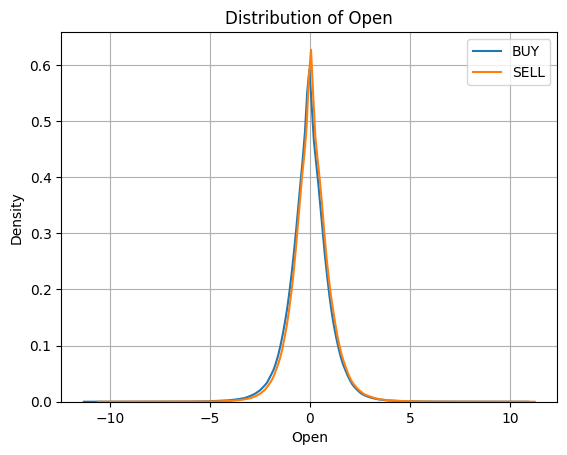

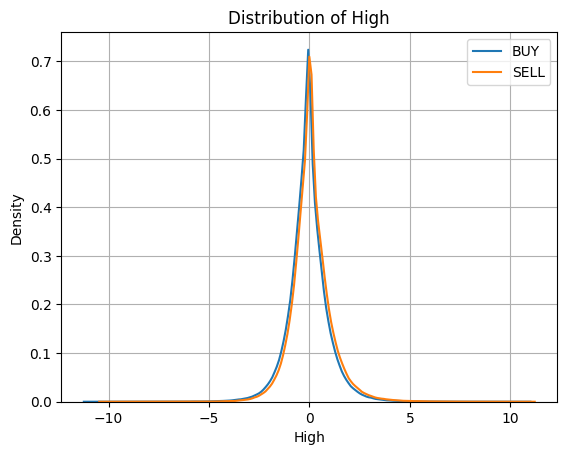

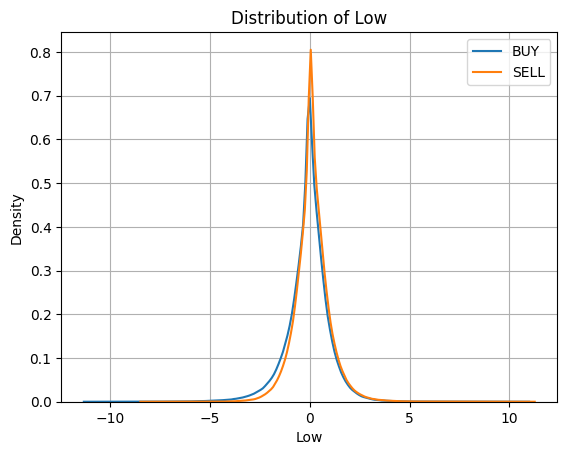

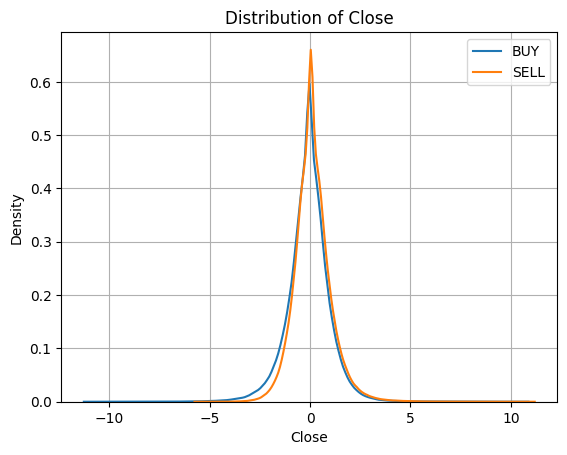

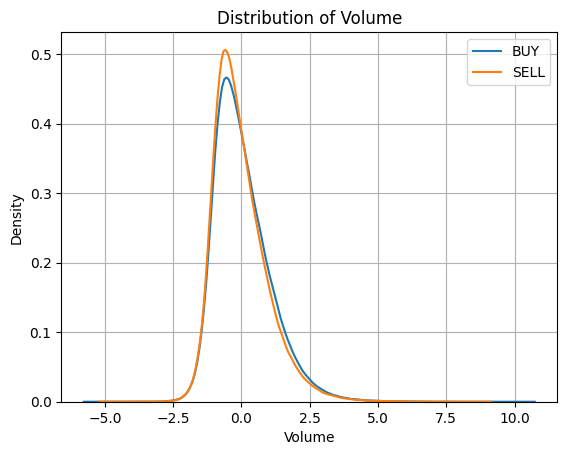

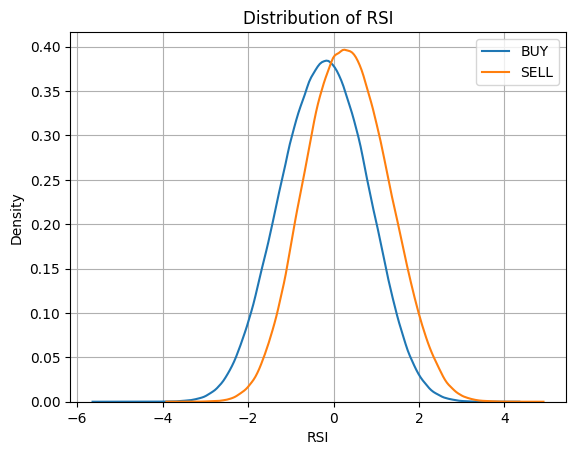

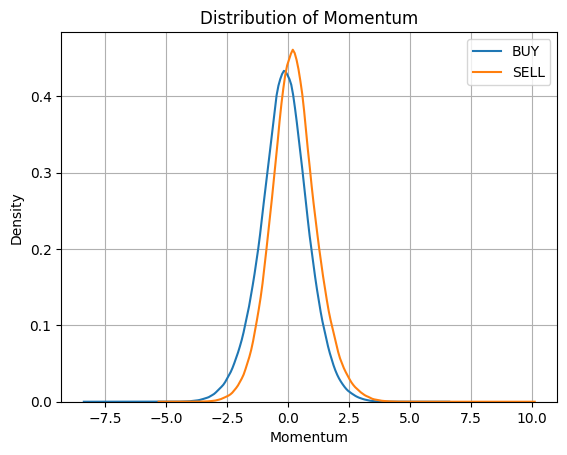

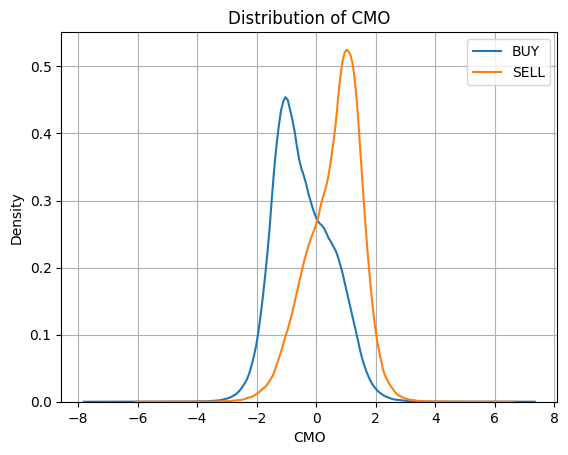

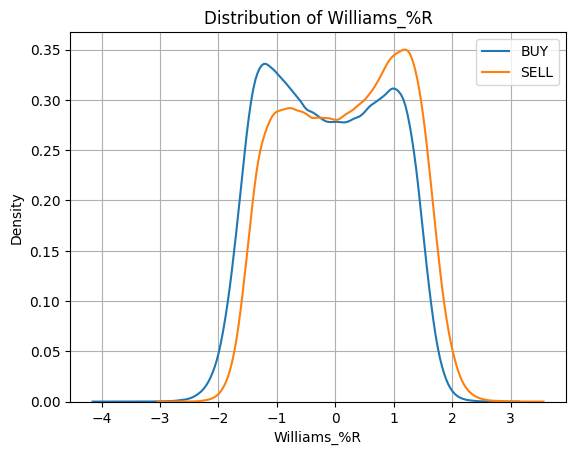

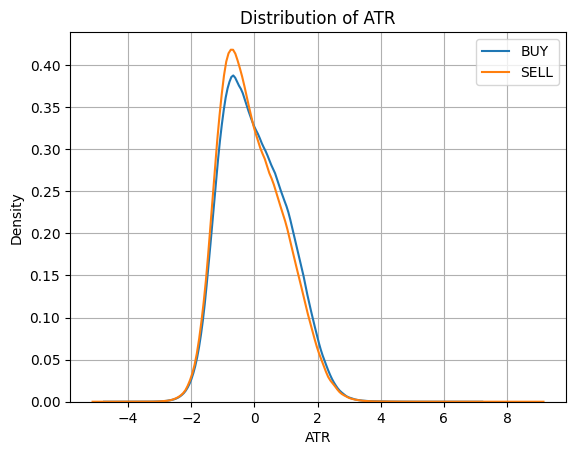

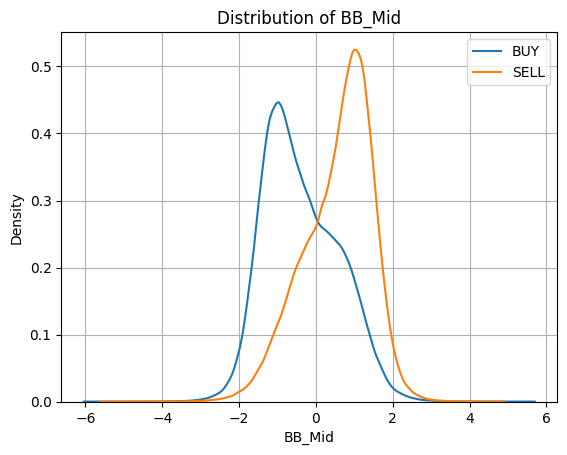

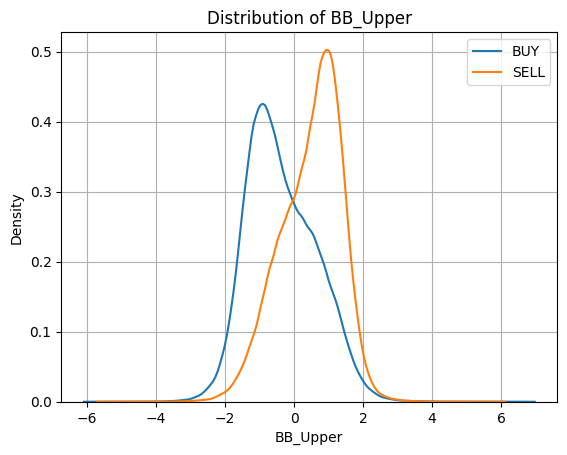

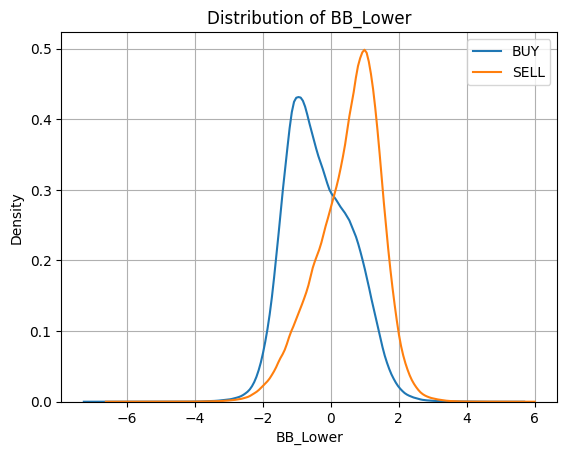

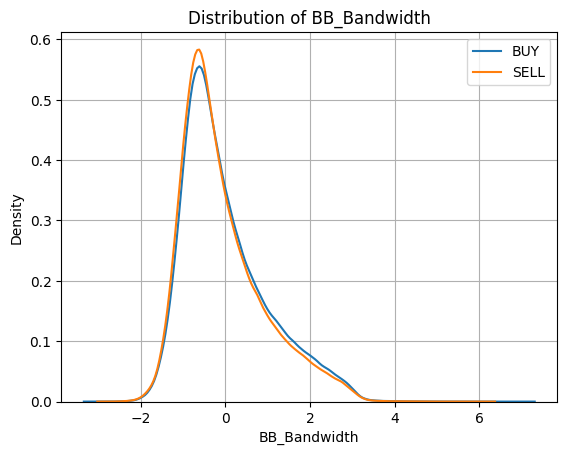

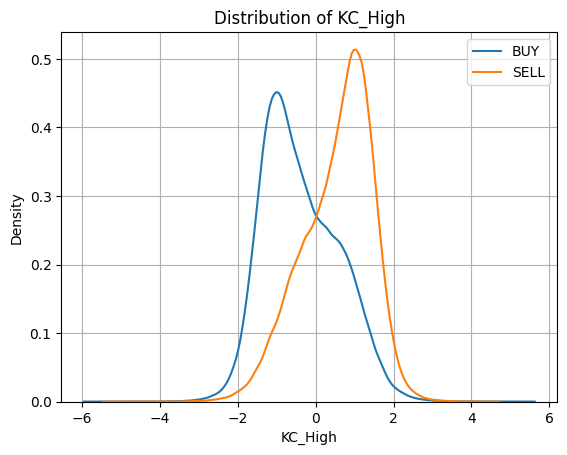

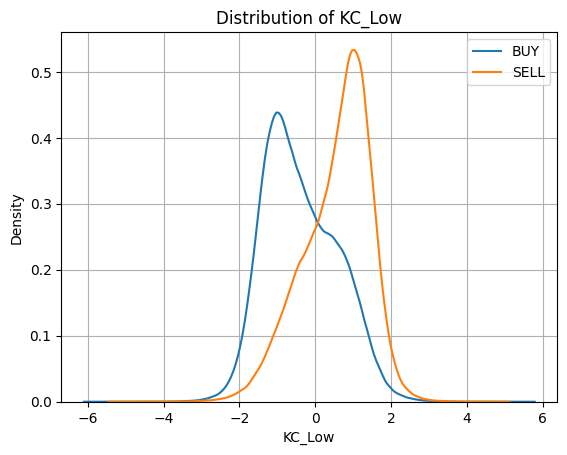

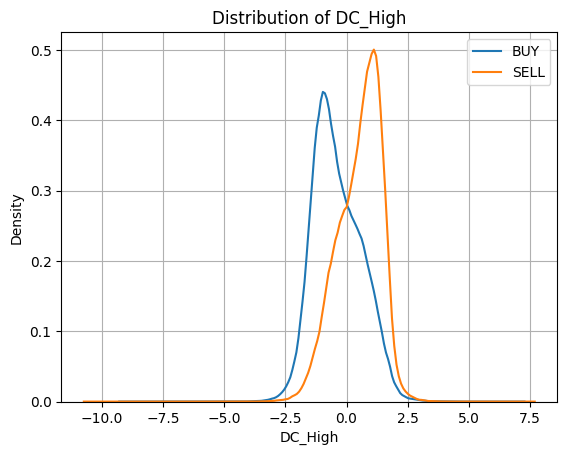

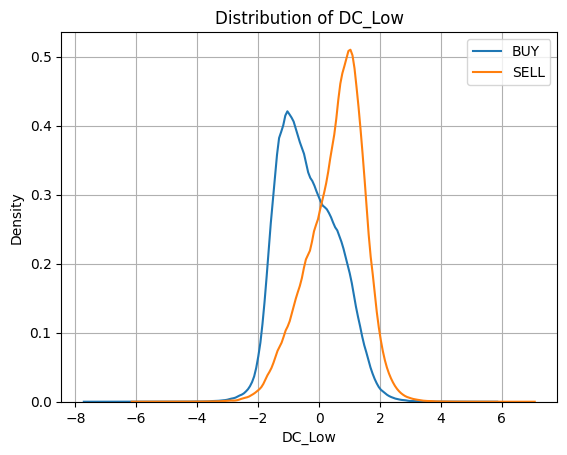

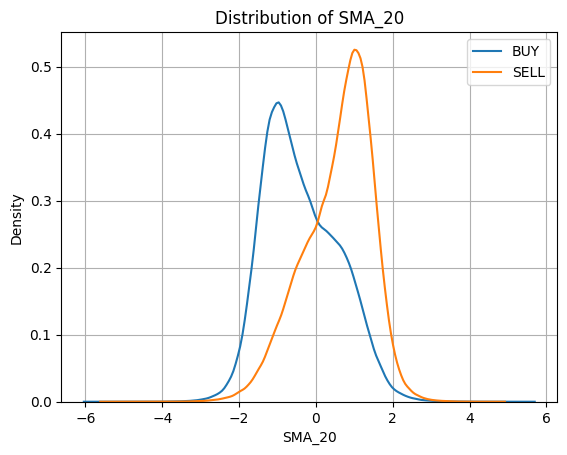

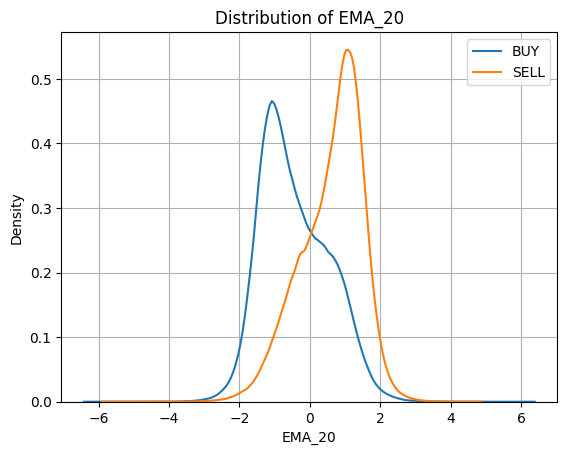

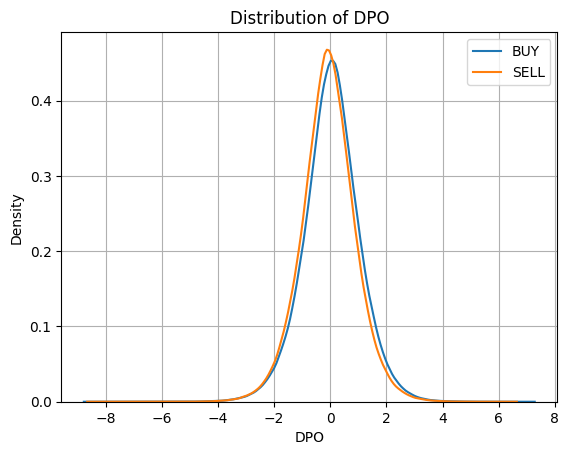

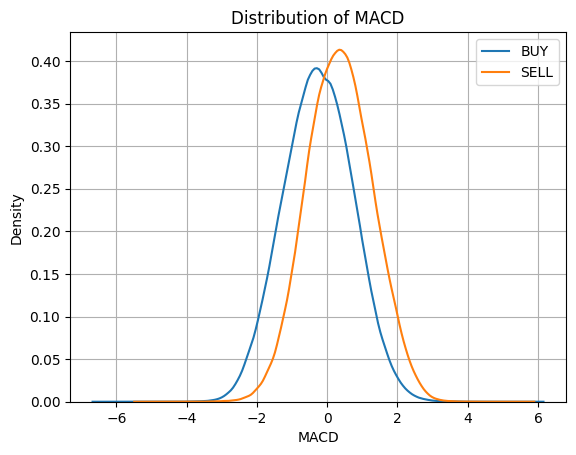

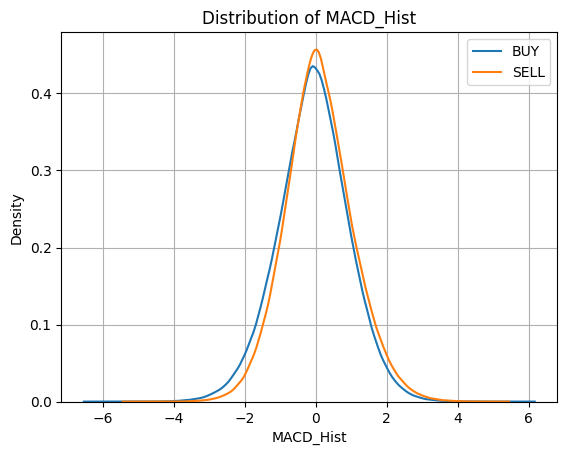

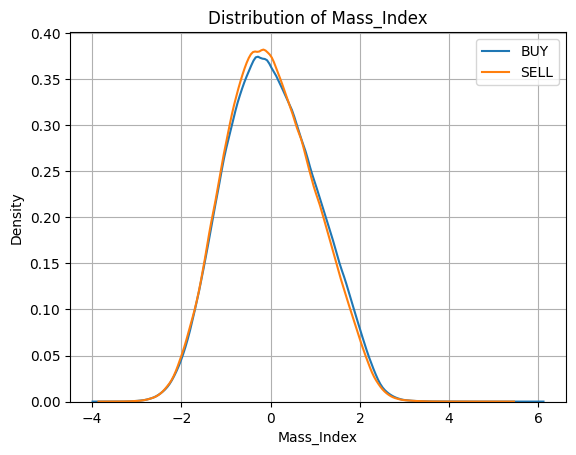

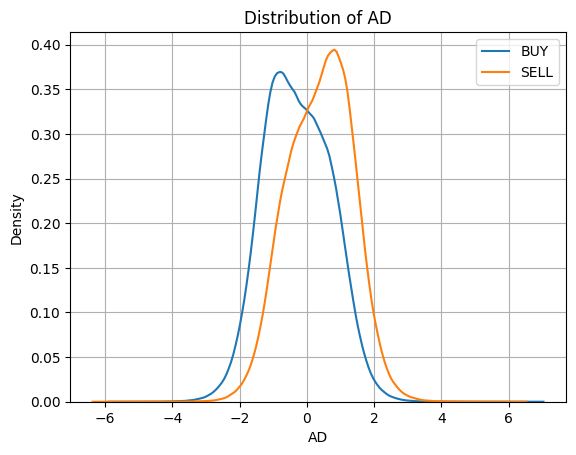

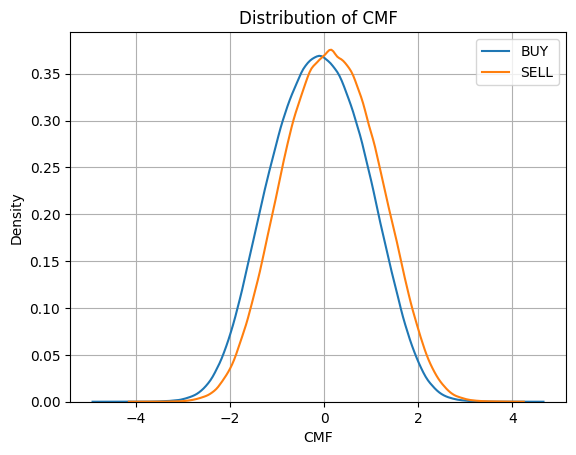

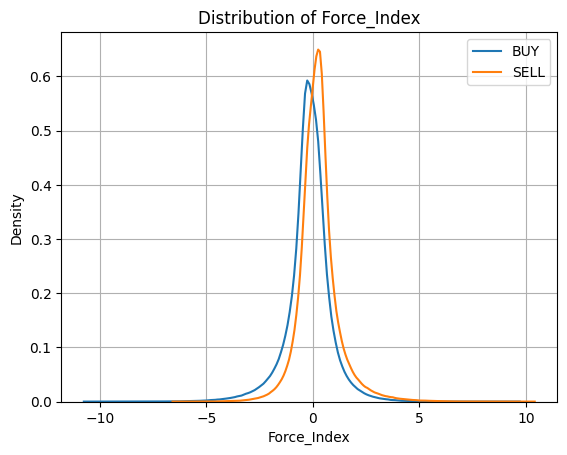

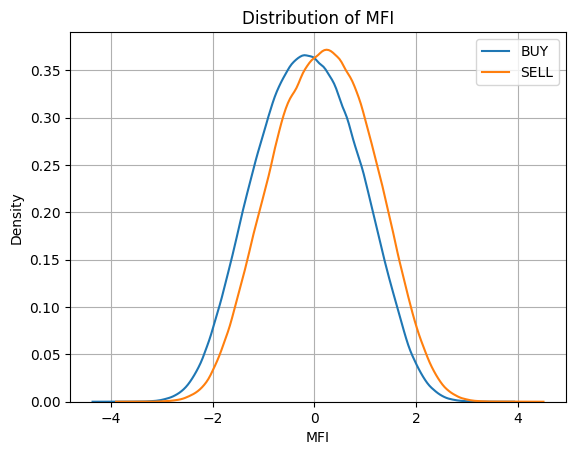

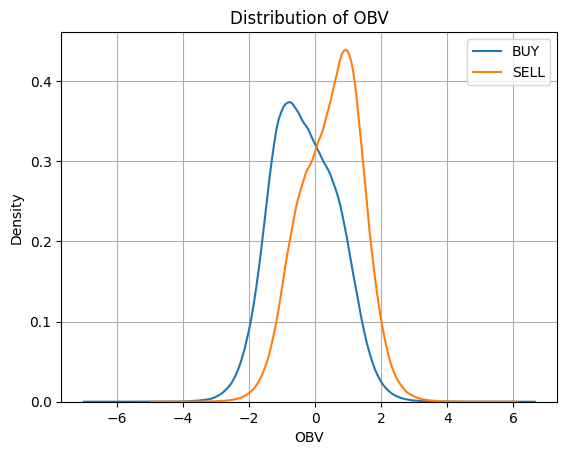

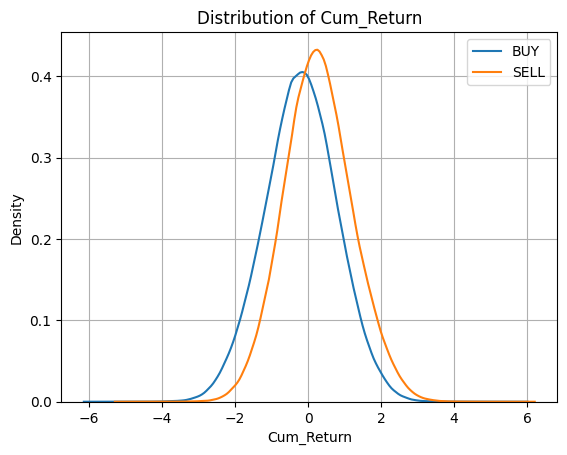

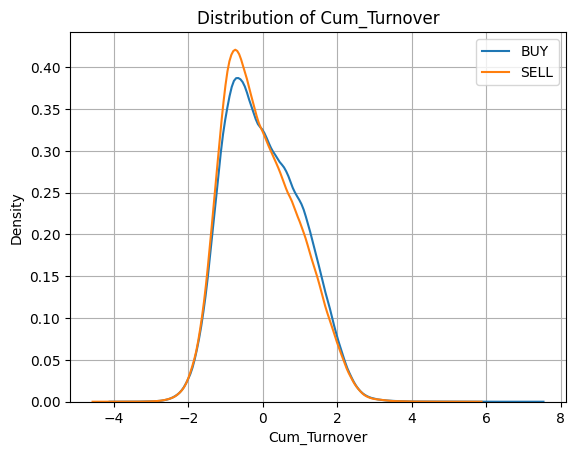

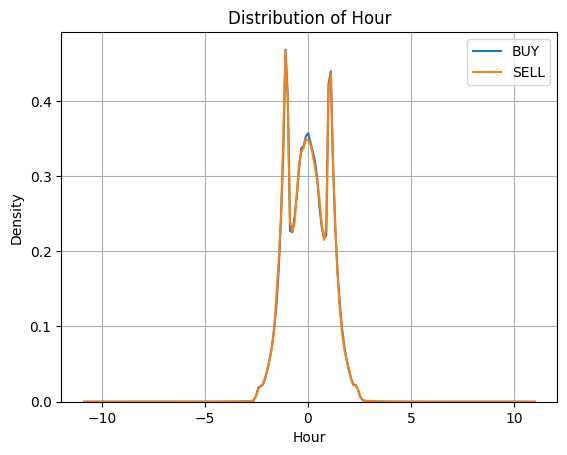

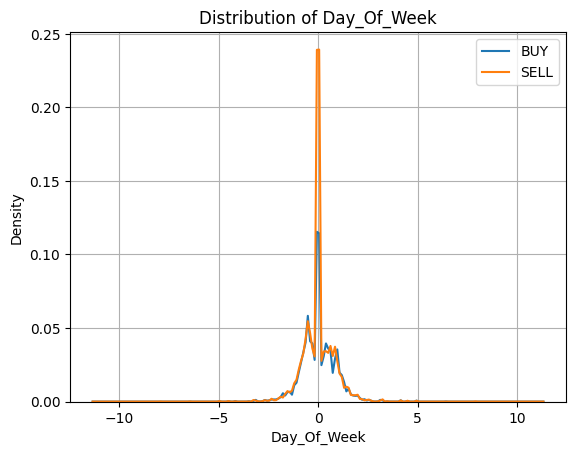

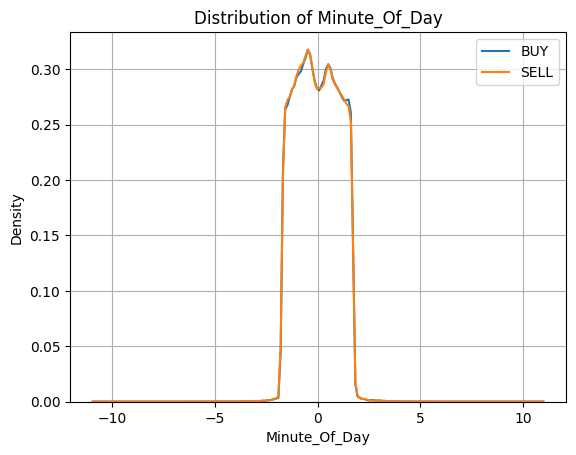

In [12]:
def visualize_kde(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
        
    buy = df[df['Label'] == 'BUY']
    sell = df[df['Label'] == 'SELL']

    feature_cols = [col for col in df.columns if col not in ['Label', 'Datetime']]
        
    for col in feature_cols:
        sns.kdeplot(buy[col], label='BUY')
        sns.kdeplot(sell[col], label='SELL')
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.grid(True)
        plt.show()

visualize_kde(train_df)

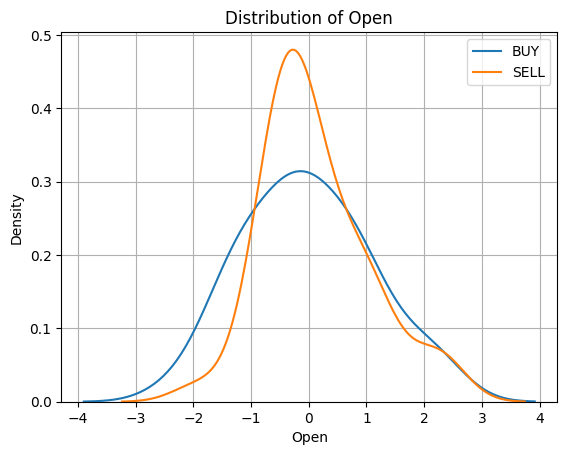

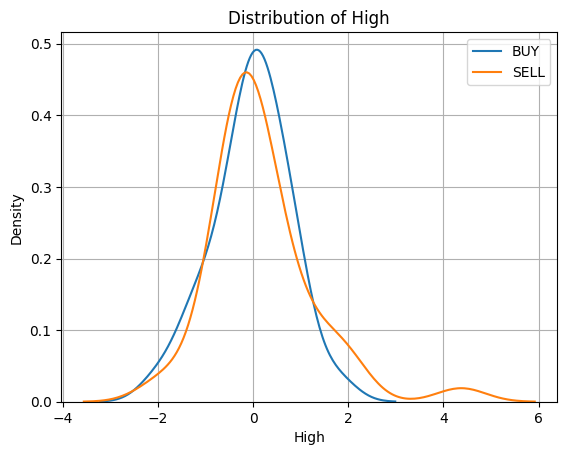

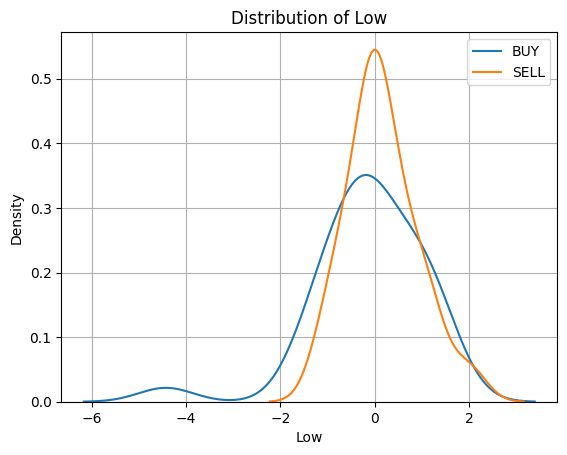

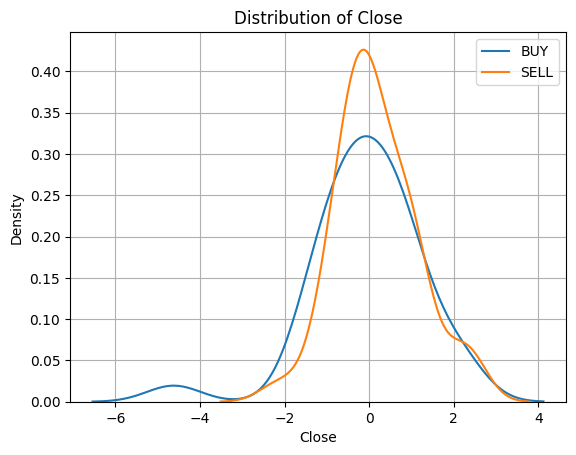

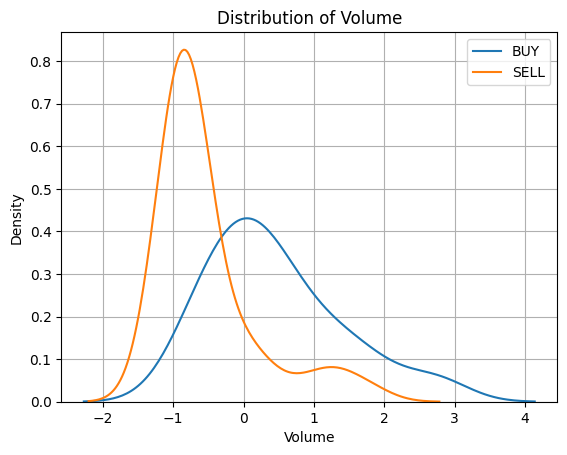

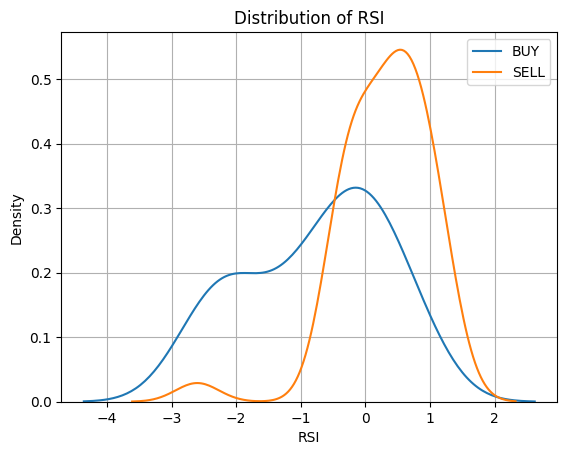

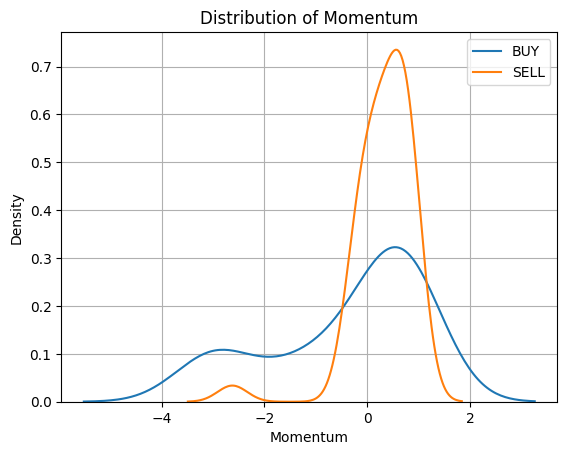

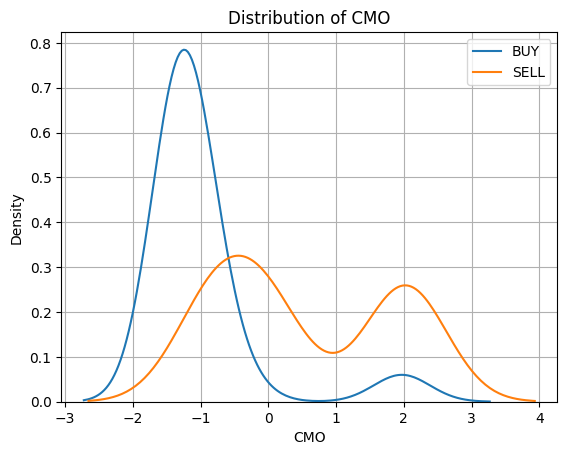

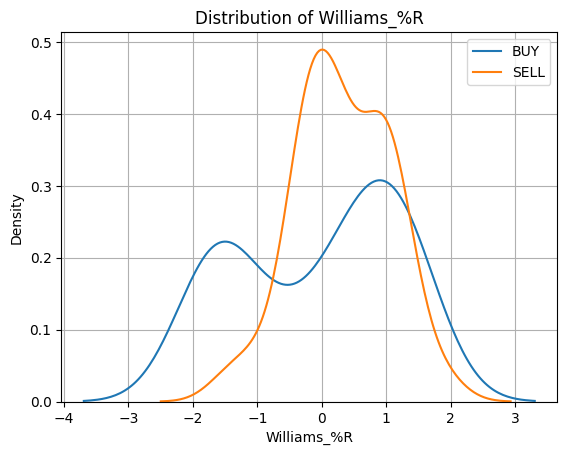

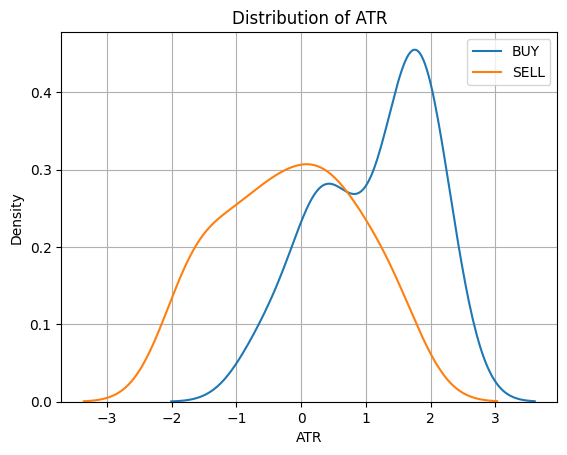

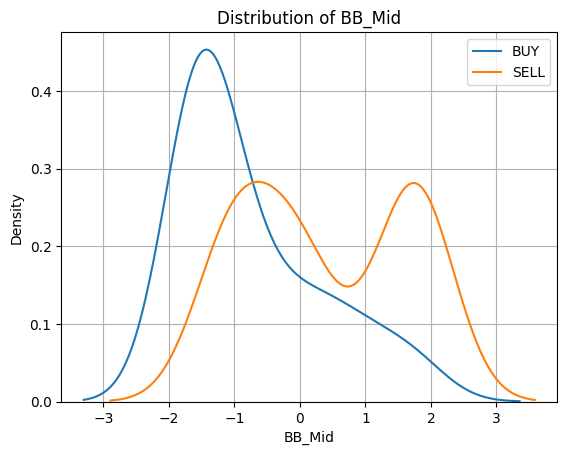

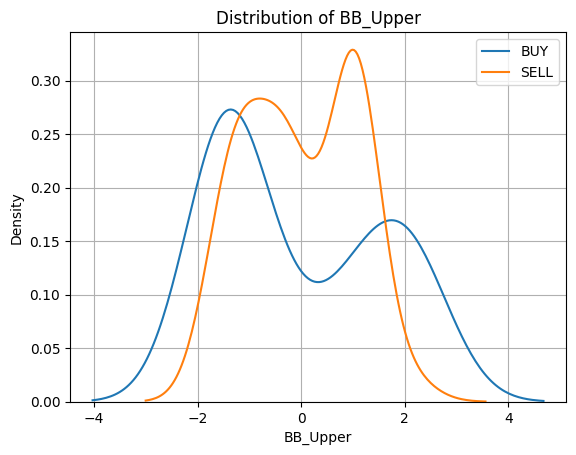

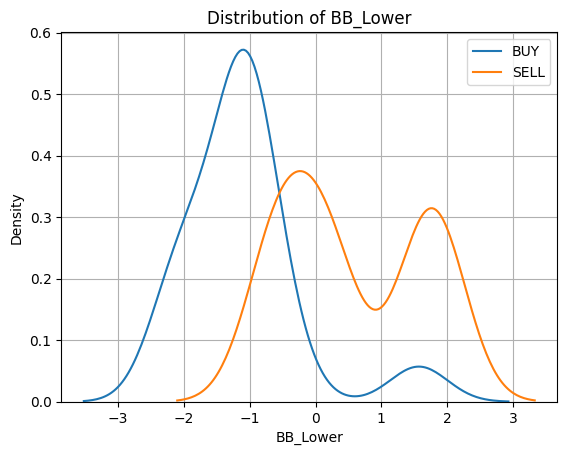

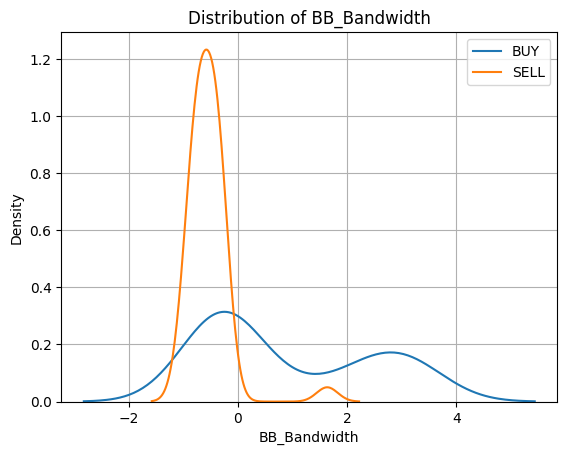

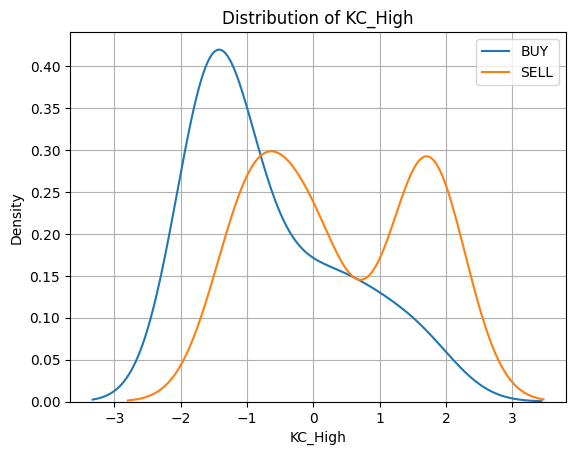

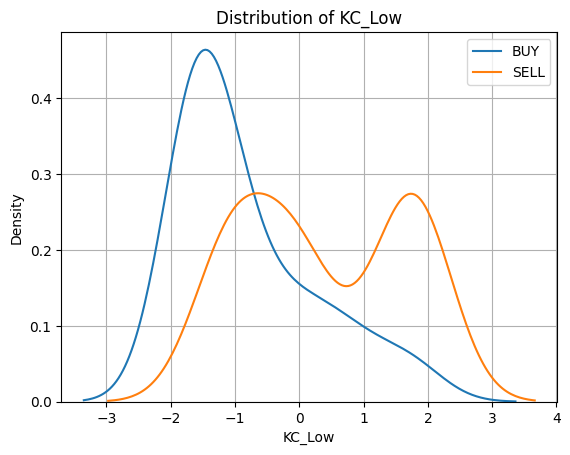

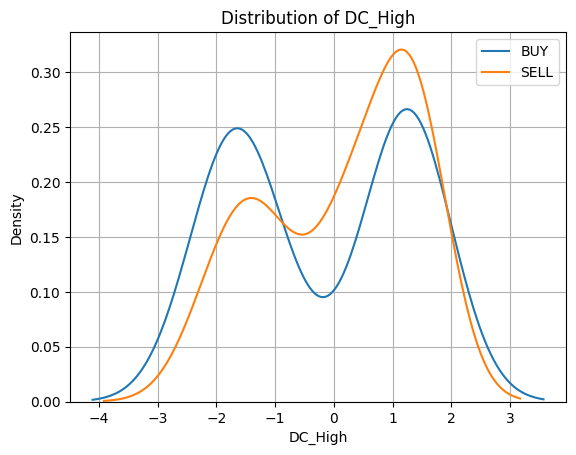

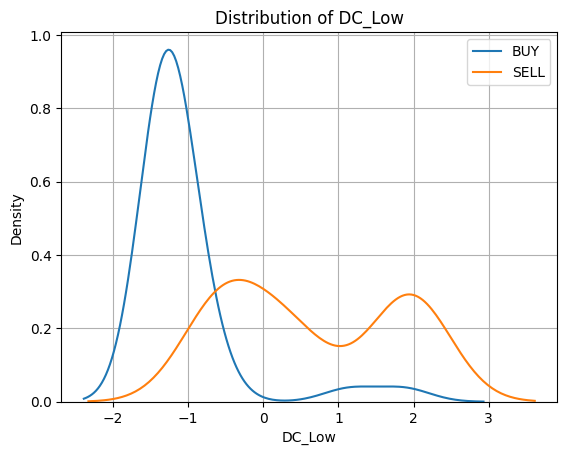

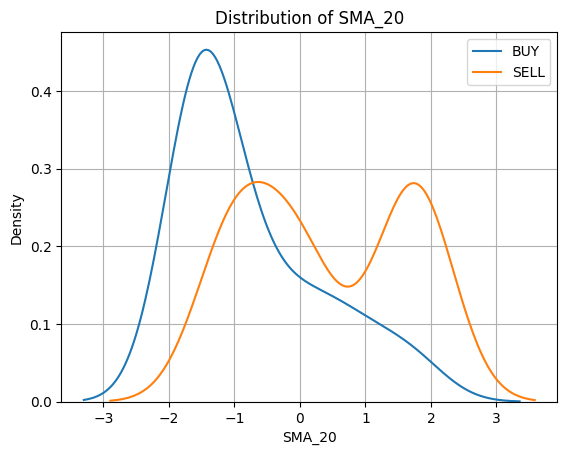

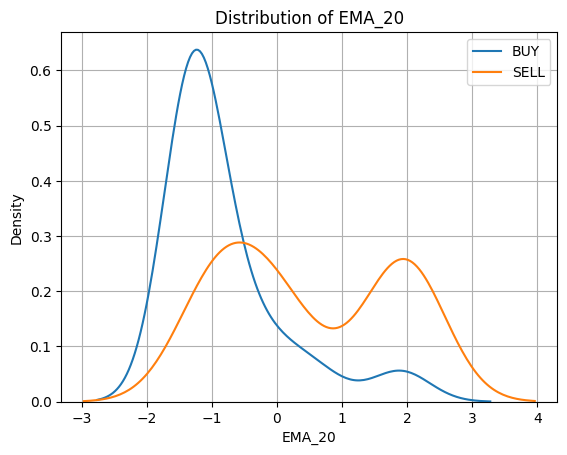

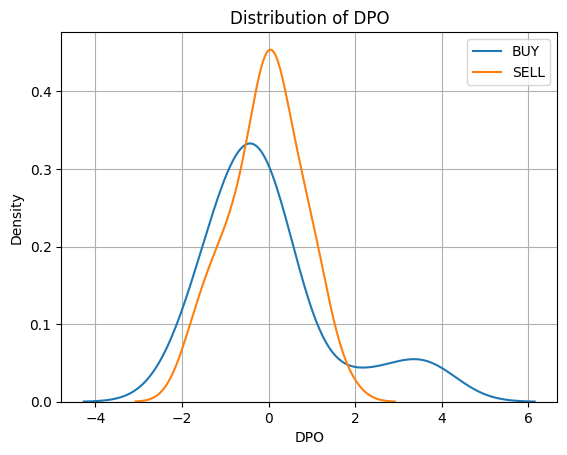

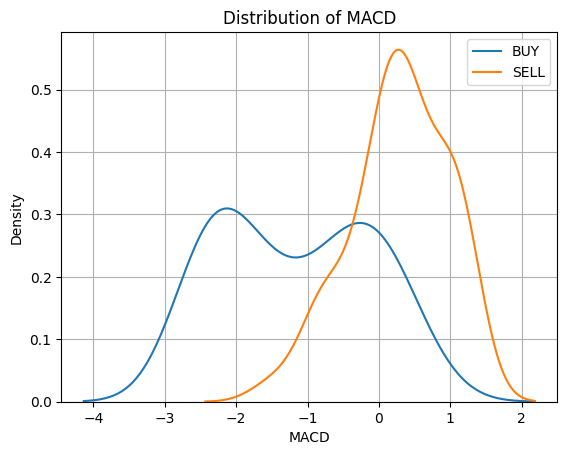

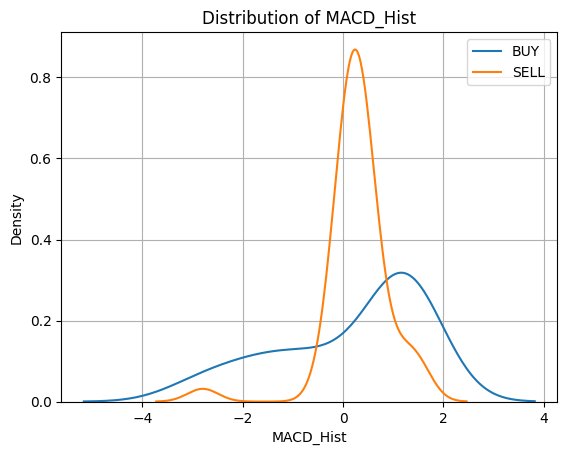

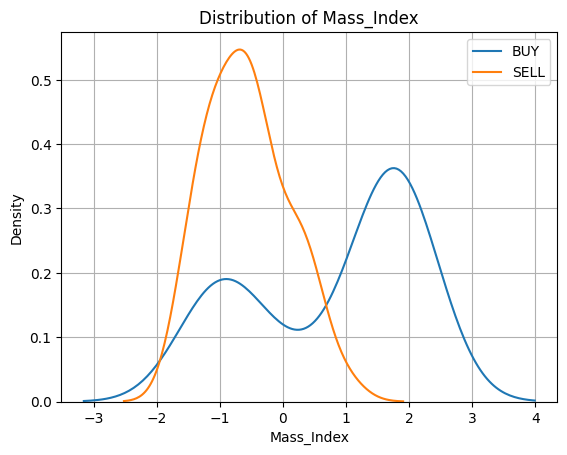

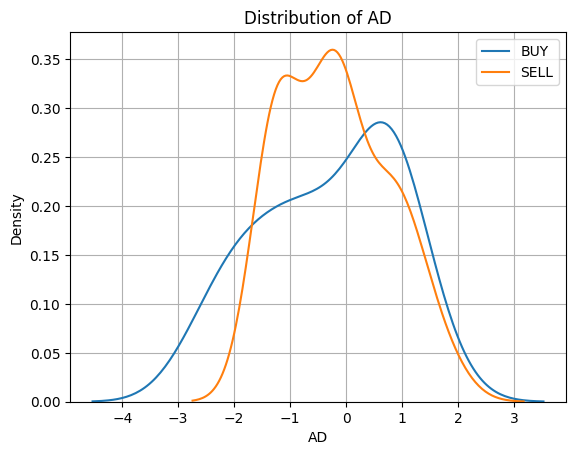

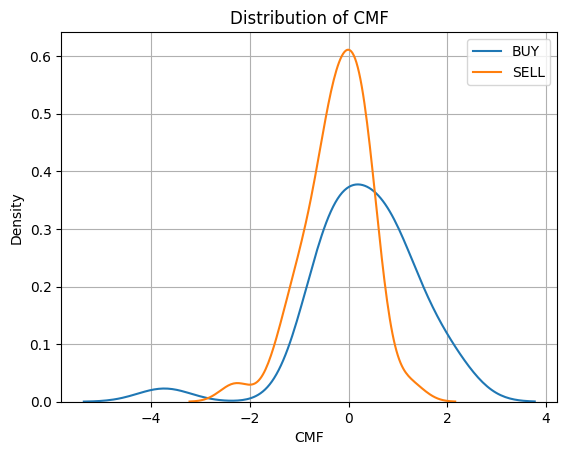

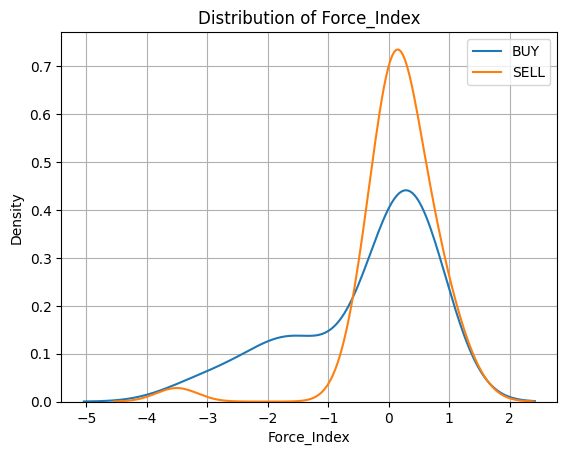

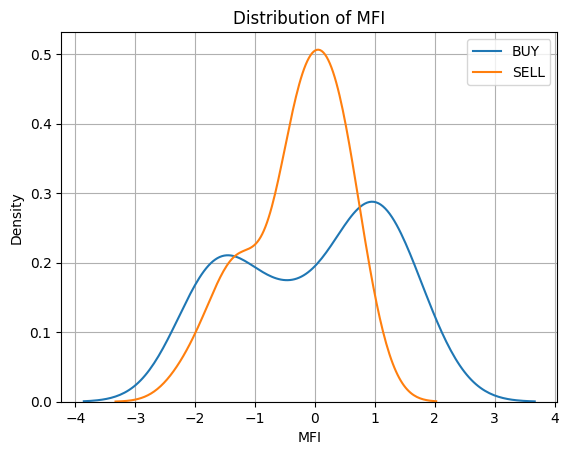

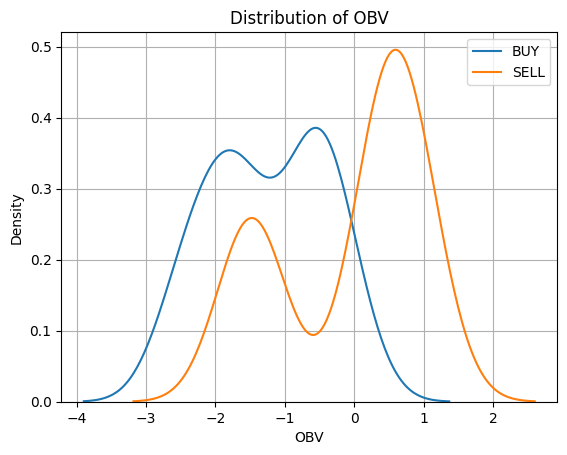

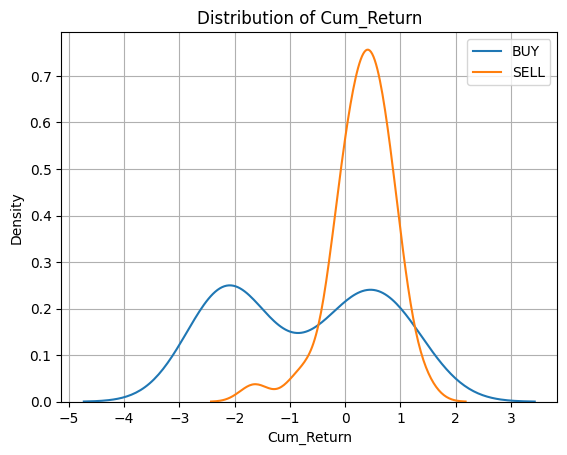

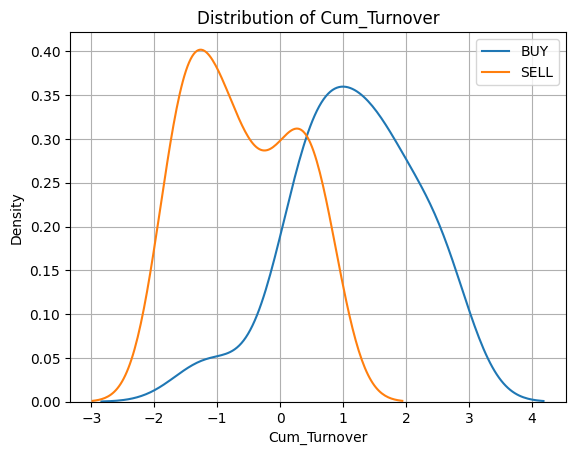

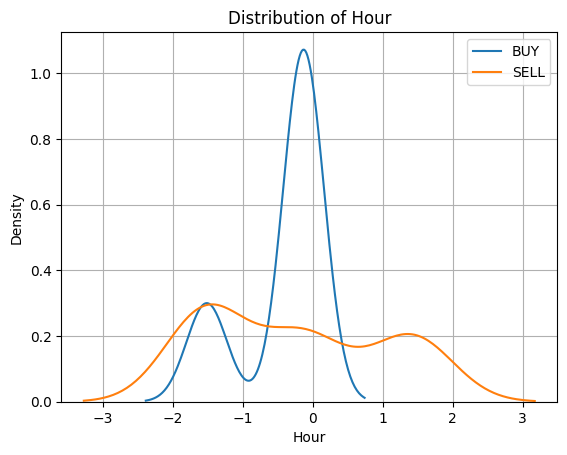

C:\Users\longt\AppData\Local\Temp\ipykernel_15808\1644597433.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(buy[col], label='BUY')
C:\Users\longt\AppData\Local\Temp\ipykernel_15808\1644597433.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(sell[col], label='SELL')
C:\Users\longt\AppData\Local\Temp\ipykernel_15808\1644597433.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


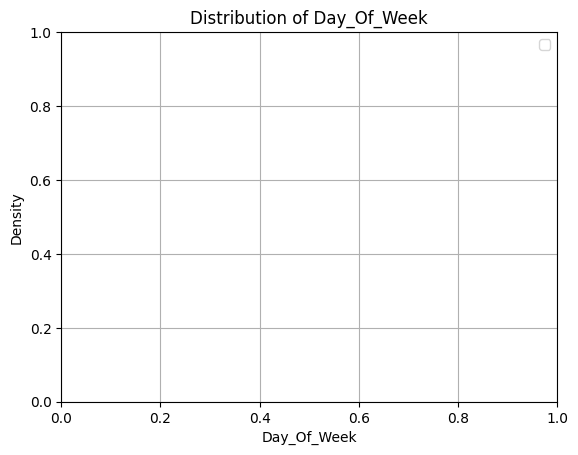

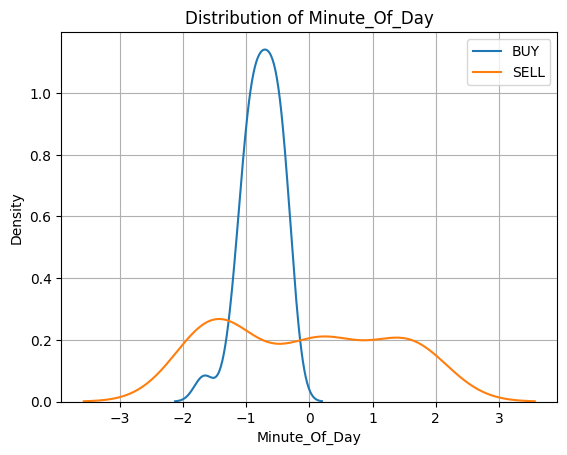

In [13]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

visualize_kde(train_df, start_dt, end_dt)

In [14]:
from sklearn.feature_selection import mutual_info_classif

def compute_mi(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
    
    df_binary = df[df['Label'].isin(['BUY', 'SELL'])]
    X = df_binary.drop(columns=['Label', 'Datetime'])
    y = df_binary['Label']

    mi = mutual_info_classif(X, y, discrete_features=False)
    mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    print(mi_series)
    
compute_mi(train_df)

DC_High          0.364112
DC_Low           0.360432
CMO              0.135391
EMA_20           0.130601
BB_Mid           0.113983
SMA_20           0.113974
KC_Low           0.109902
KC_High          0.108744
BB_Lower         0.097682
BB_Upper         0.093824
OBV              0.086182
AD               0.062789
RSI              0.051788
MACD             0.047055
Volume           0.043556
Williams_%R      0.035129
Cum_Return       0.031349
Force_Index      0.029786
Momentum         0.023833
Hour             0.022945
Low              0.017794
Close            0.017170
High             0.013998
Cum_Turnover     0.013126
MFI              0.012832
CMF              0.009628
Open             0.009392
DPO              0.003832
MACD_Hist        0.003751
Day_Of_Week      0.001848
Minute_Of_Day    0.001530
BB_Bandwidth     0.001213
ATR              0.001081
Mass_Index       0.000036
dtype: float64


In [15]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

compute_mi(train_df, start_dt, end_dt)

Minute_Of_Day    0.591586
DC_Low           0.524324
CMO              0.519607
BB_Lower         0.500001
OBV              0.452330
BB_Bandwidth     0.352522
Cum_Turnover     0.337621
Mass_Index       0.294802
KC_High          0.287425
EMA_20           0.281460
DC_High          0.279240
SMA_20           0.275968
BB_Mid           0.275968
BB_Upper         0.264286
MACD             0.255456
MACD_Hist        0.249966
KC_Low           0.228281
Volume           0.227116
RSI              0.221947
ATR              0.217491
Force_Index      0.213044
Momentum         0.185581
CMF              0.149828
MFI              0.146293
Williams_%R      0.146103
AD               0.118454
Hour             0.117141
Cum_Return       0.096616
Day_Of_Week      0.091805
Open             0.071764
Close            0.062565
DPO              0.053502
Low              0.034106
High             0.026142
dtype: float64


In [16]:
def corr_with_bin(df, start_dt=None, end_dt=None):
    df = df.copy()
    if start_dt and end_dt:
        start_dt = pd.to_datetime(start_dt)
        end_dt = pd.to_datetime(end_dt)
        df = df[(df['Datetime'] >= start_dt) & (df['Datetime'] <= end_dt)]
    
    df_binary = df[df['Label'].isin(['BUY', 'SELL'])]
    X = df_binary.drop(columns=['Label', 'Datetime'])
    y = df_binary['Label']
    
    df_binary['Label_num'] = df_binary['Label'].map({'BUY': 1, 'SELL': 0})
    correlations = df_binary.drop(columns=['Label', 'Datetime']).corrwith(df_binary['Label_num'])
    print(correlations.abs().sort_values(ascending=False))
    
corr_with_bin(train_df)

C:\Users\longt\AppData\Local\Temp\ipykernel_15808\3228566864.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['Label_num'] = df_binary['Label'].map({'BUY': 1, 'SELL': 0})


Label_num        1.000000
CMO              0.482089
EMA_20           0.476843
SMA_20           0.443964
BB_Mid           0.443964
KC_Low           0.438973
KC_High          0.436290
DC_Low           0.429557
DC_High          0.420338
BB_Lower         0.409982
BB_Upper         0.394771
OBV              0.376385
AD               0.318267
MACD             0.296130
RSI              0.265563
Cum_Return       0.234698
Force_Index      0.216814
Momentum         0.195264
MFI              0.150538
Williams_%R      0.148757
CMF              0.126919
Close            0.105129
Low              0.098557
MACD_Hist        0.082330
High             0.078410
DPO              0.060573
Open             0.054758
ATR              0.046188
Volume           0.040798
BB_Bandwidth     0.035696
Cum_Turnover     0.035523
Mass_Index       0.019932
Hour             0.004522
Minute_Of_Day    0.003225
Day_Of_Week      0.000402
dtype: float64


In [17]:
start_dt = '2018-11-20 10:00:00'
end_dt = '2018-11-20 12:00:00'

corr_with_bin(train_df, start_dt, end_dt)

Label_num        1.000000
Cum_Turnover     0.698922
DC_Low           0.666063
BB_Lower         0.660346
MACD             0.649083
CMO              0.579103
Mass_Index       0.577973
BB_Bandwidth     0.573760
ATR              0.558875
OBV              0.538676
Volume           0.518325
RSI              0.511159
EMA_20           0.498884
Cum_Return       0.474083
KC_Low           0.469240
SMA_20           0.452798
BB_Mid           0.452798
KC_High          0.423359
Momentum         0.312872
Minute_Of_Day    0.312494
CMF              0.295775
Force_Index      0.288125
Williams_%R      0.196960
Low              0.150724
MFI              0.123246
DC_High          0.112029
Close            0.108879
High             0.103660
Hour             0.090862
Open             0.071467
MACD_Hist        0.063496
AD               0.056010
DPO              0.034622
BB_Upper         0.024890
Day_Of_Week           NaN
dtype: float64


C:\Users\longt\AppData\Local\Temp\ipykernel_15808\3228566864.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['Label_num'] = df_binary['Label'].map({'BUY': 1, 'SELL': 0})
c:\Users\longt\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\longt\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
